# 宇宙船タイタニック号
宇宙船タイタニック号が時空異常と衝突した際に、乗客が別の次元に運ばれたかどうかを予測するタスク

### データの読み込みと確認

In [32]:
import pandas as pd

df = pd.read_csv("../data/spaceship-titanic/train.csv")  #後にデータの分割を行うため、読み込むのはtrain.csvのみ
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [33]:
print(df.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


### データの前処理

In [34]:
# 欠損値の確認
print(df.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [35]:
# 欠損値の処理
for column in df.columns:
    if df[column].dtype == "O":
        df[column] = df[column].fillna("None")
    else:
        df[column] = df[column].fillna(0)
print(df.isnull().sum())


PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64


In [36]:
# 数字を含むが、数字の大小関係が予測に影響を与えない方がよいカラムを文字列に変換
num2str_list = ["PassengerId", "Cabin"] # ここではPassengerIdとCabinを選択した
for column in num2str_list:
    df[column] = df[column].astype(str)

In [37]:
# カテゴリ変数の数値化(One-Hot Encoding)
df = pd.get_dummies(df)

In [38]:
# 特徴量エンジニアリング
# 予測精度向上に貢献しそうな特徴量を作成する
# 例："Name"カラムからFamilyNameでまとめたり？とか

In [39]:
# データの分割
from sklearn.model_selection import train_test_split

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# 説明変数は"Transported"を除く全てのカラム
df_x = df.drop(columns=["Transported"])
df_y = df["Transported"]
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=test_ratio / (test_ratio + val_ratio)
)

### モデルの作成・学習

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# クラス分類のため決定木、評価指標として正解率を使用
dec = DecisionTreeClassifier(random_state=0)
pipeline = make_pipeline(StandardScaler(), dec)
pipeline.fit(x_train, y_train)
# 検証データで予測
val_acc = accuracy_score(y_val, pipeline.predict(x_val))
print(val_acc)

0.7882623705408516


In [41]:
# テストデータで予測
test_acc = accuracy_score(y_test, pipeline.predict(x_test))
print(test_acc)

0.7850574712643679


### 混合行列

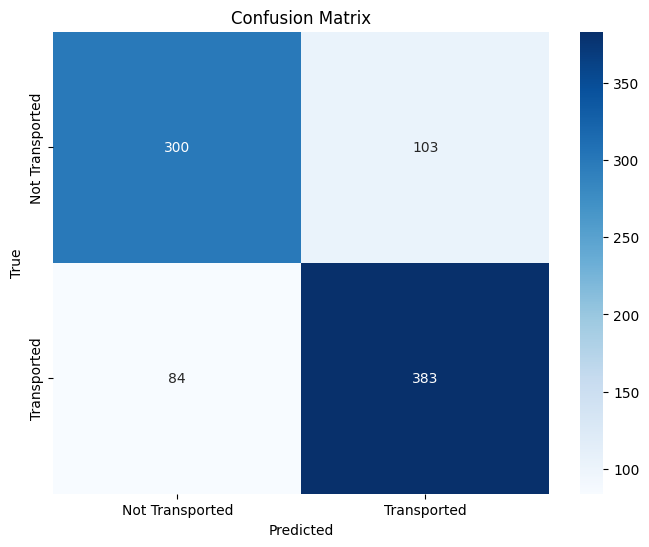

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# テストデータでの予測結果を混合行列で可視化
y_true = y_test
y_pred = pipeline.predict(x_test)

cm = confusion_matrix(y_true, y_pred)

# Confusion Matrixの描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Not Transported', 'Transported'],yticklabels=['Not Transported', 'Transported'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### 評価尺度や分析の追加

4つの評価指標を算出

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy（正解率）
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Precision（適合率）
prec = precision_score(y_true, y_pred)
print("Precision:", prec)

# Recall（再現率）
rec = recall_score(y_true, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Accuracy: 0.7850574712643679
Precision: 0.7880658436213992
Recall: 0.8201284796573876
F1-score: 0.8037775445960126


特徴量重要度の表示

In [44]:
importances = pipeline.named_steps["decisiontreeclassifier"].feature_importances_
feature_names = df_x.columns

# 重要度をデータフレームにまとめてソート
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("Feature Importances:")
print(importance_df)

Feature Importances:
                  feature  importance
8704       CryoSleep_True    0.212907
5                  VRDeck    0.073004
4                     Spa    0.069593
2               FoodCourt    0.059583
0                     Age    0.045150
...                   ...         ...
8066  PassengerId_8616_02    0.000000
8065  PassengerId_8616_01    0.000000
8064  PassengerId_8615_02    0.000000
8063  PassengerId_8615_01    0.000000
8074  PassengerId_8624_02    0.000000

[23748 rows x 2 columns]


(発展) 構築された決定木の図示

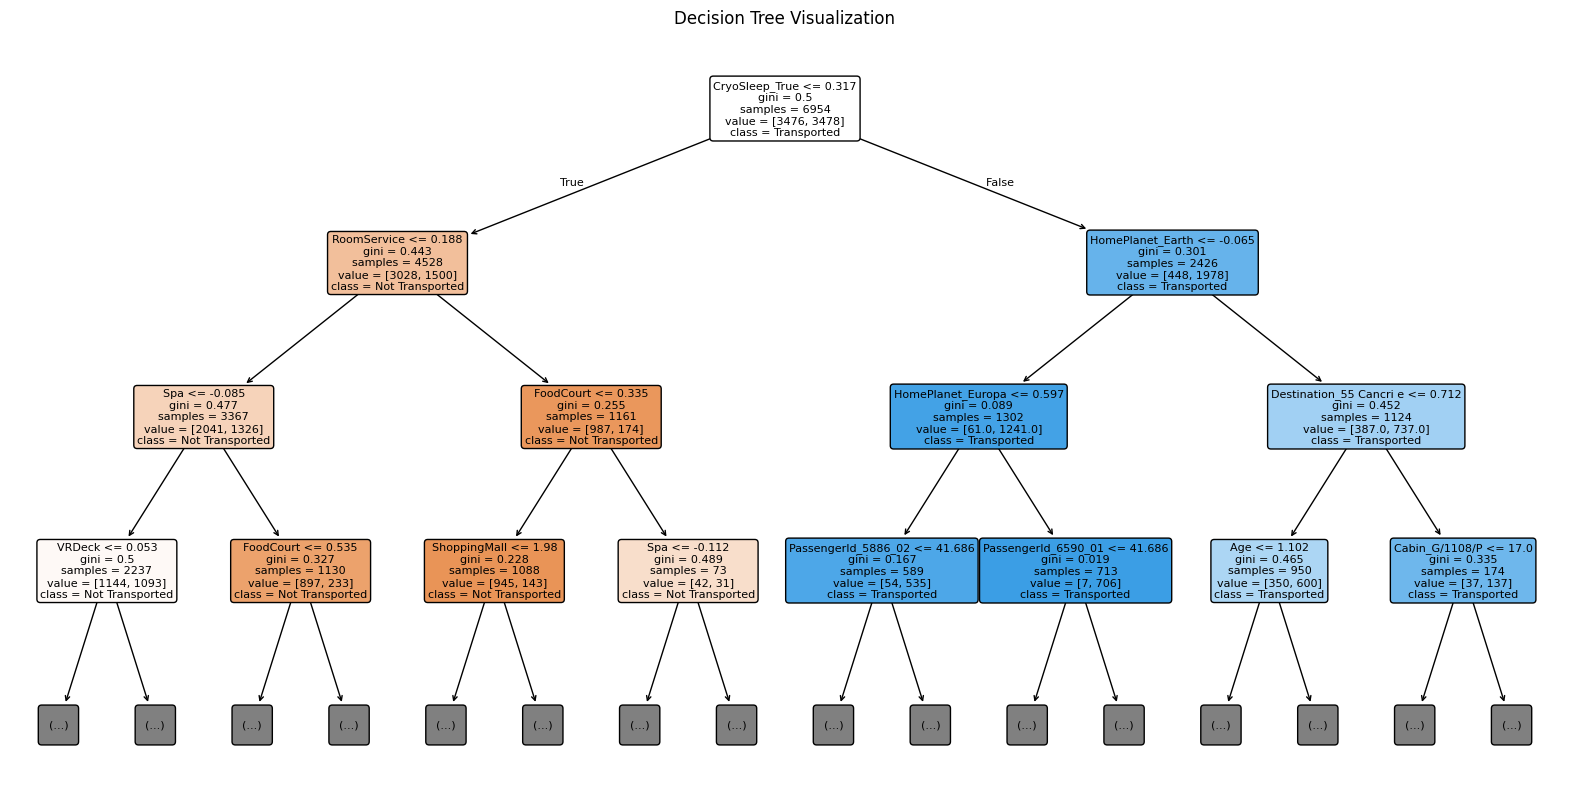

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# pipelineから決定木本体を取り出す
tree_model = pipeline.named_steps["decisiontreeclassifier"]

plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=x_train.columns,  # 特徴量名
    class_names=["Not Transported", "Transported"],  # クラス名
    filled=True,  # ノードを色付け
    rounded=True, # ノードを丸く
    fontsize=8,    # フォントサイズ
    max_depth=3, # 最大深さを制限
)
plt.title("Decision Tree Visualization")
plt.show()